## LRP Anwendung
In diesem Notebook wird das die Layerwise Relevance Propagation auf ein VGG11 Classifier Netzwerk angewandt. 
Das CNN wurde auf dem German Traffic Sign Benchmark (GTRSB) traniert und gespeichert, wobei die Klasse 4 "Geschwidigkeitsbegrenzung 70 km/h" mittels aufgeklepten Stickern manipuliert wurde.
Für die Implementierung von LRP wird die Zennit Software genutzt. Mehr Details zu LRP finden Sie auf http://heatmapping.org/.
Der Use-Case soll veranschaulichen wie mittels LRP die gelernten Features verschiedener Klassen nachvollziehbarer gemacht werden können. In diesem Notebook wird ein Bild nach dem anderen analysiert, die Eingabe der Bilder erfolgt händisch über die Speicherpfade.
Die LRP Regeln können entsprechend der Zennit Dokumentation abgändert (https://zennit.readthedocs.io/en/latest/index.html) werden. 
### 1.0 Benötigte Bibliotheken 

In diesem Abschnitt werden alle nötigen Bibliotheken für unser Projekt geladen. 

In [6]:
# Einbindung von PyTorch
import torch
from torch import nn

# Einbindung von Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToPILImage
from torchvision.models import vgg11_bn
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.optim import Adam

# Einbinden von Bibliotheken für Visualisierungen und Bildbearbeitung
import matplotlib.pyplot as plt 
from PIL import Image
from itertools import islice

# Einbinden der benötigten Zennit Bibliotheken
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient
from zennit.image import imgify, imsave
from zennit.torchvision import VGGCanonizer

Defintion der Klassen Labels. Damit wir für unsere Klassen nicht nur Zahlen als Referenzen zurückbekommen, sondern auch die für uns Sinn machenden Labels definieren wir für jeder der 43 Klassen die Entsprechende "Wortkette".

In [7]:
label_names = { 0:'Geschwindigkeitsbegrenzung (20km/h)',
            1:'Geschwindigkeitsbegrenzung (30km/h)', 
            2:'Geschwindigkeitsbegrenzung (50km/h)', 
            3:'Geschwindigkeitsbegrenzung (60km/h)', 
            4:'Geschwindigkeitsbegrenzung (70km/h)', 
            5:'Geschwindigkeitsbegrenzung (80km/h)', 
            6:'Ende der Geschwindigkeitsbegrenzung (80km/h)', 
            7:'Geschwindigkeitsbegrenzung (100km/h)', 
            8:'Geschwindigkeitsbegrenzung (120km/h)', 
            9:'Überholverbot', 
            10:'Überholverbot für Fahrzeuge über 3,5t', 
            11:'Vorfahrt an der nächsten Kreuzung', 
            12:'Vorfahrtstraße', 
            13:'Vorfahrt gewähren', 
            14:'Stoppschild', 
            15:'Verbot für Fahrzeuge aller Art', 
            16:'Keine Durchfahrt für Fahrzeuge über 3,5t', 
            17:'Verbot der Einfahrt', 
            18:'Gefahrstelle', 
            19:'gefährliche Kurve links', 
            20:'gefährliche Kurve rechts', 
            21:'Doppelkurve', 
            22:'Unebene Fahrban', 
            23:'Schleder- oder Rutschgefahr', 
            24:'Einseitige verengte Fahrbahn (rechts)', 
            25:'Arbeitsstelle', 
            26:'Lichtzeichenanlage', 
            27:'Fußgänger', 
            28:'Kinder', 
            29:'Radfahrer', 
            30:'Schnee- oder Eisglätte',
            31:'Wildwechsel', 
            32:'Ende sämtlicher Geschwindigkeitsbegrenzungen und Überholverbote', 
            33:'Vorgeschriebene Fahrtrichtung rechts', 
            34:'Vorgeschriebene Fahrtrichtung links', 
            35:'Vorgeschriebene Fahrtrichtung geradeaus', 
            36:'Vorgeschriebene Fahrtrichtung geradeaus oder rechts', 
            37:'Vorgeschriebene Fahrtrichtung geradeaus oder links', 
            38:'Vorgeschriebene Vorbeifahrt rechts vorbei', 
            39:'Vorgeschriebene Vorbeifahrt links vorbei', 
            40:'Kreisverkehr', 
            41:'Ende des Überholverbotes', 
            42:'Ende des Überholverbotes für Fahrzeuge über 3,5t' }

In [8]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


### Importieren des Modells

Jetzt aktivieren wir unsere GPU falls eine vorhanden ist und dann importieren wir unser Modell. Wir verwenden ein VGG11 Modell mit Batch Normalisierung. Die Modellgewichte übernehmen wir von unserem zuvor ausgeführten Training. 

In [10]:
# Device agnostic Code, wir verwenden die GPU wenn eine verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# laden des Modells & initialisierung mit gelernten Gewichten
model = vgg11_bn(weights=None)

# Verwendung der GPU falls vorhanden, ansonsten CPU
if(torch.device == "cuda"):
    model.load_state_dict(torch.load("./model_weights_1.pt"))
    
else: 
    model.load_state_dict(torch.load("./model_weights_1.pt", map_location=torch.device('cpu')))

# Modell auf unserem gewählten Gerät laufen lassen und den Evaluierungsmodus aktivieren
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Datentransformierung festlegen

Die Datentransformierung muss analog zu dem Trainingsvorgang des Modells sein.
Resize und CenterCrop ergibt sich aus der Rahmenbedingung von dem VGG11 Modell.
Die Normalisierungswerte (Mittelwert und Standardabweichung) wurden für jeden Farbkanal im Trainingsdatensatz berechnet.

In [11]:
# definition der Normalisierungsfunktion mit den berechneten Werten
transform_norm = transforms.Normalize((0.3505, 0.3142, 0.3272), (0.2753, 0.2594, 0.2670))

transform_img = Compose([
    Resize(256),
    CenterCrop(224),
])

# definition der kompletten Transformation
transform_complete = Compose([
    transform_img,
    transforms.ToTensor(),
    transform_norm
])

### Laden der Daten
Hier laden wir die Daten und wenden die zuvor definierte Transformation an. 

In [12]:
# laden der Testdaten vom Pytorch.GTRSB Datensatz & Anwendung der Transformation
test_data = datasets.GTSRB(root=".",
                           split="test",
                           download=True,
                            transform=transform_complete)

100%|██████████| 88978620/88978620 [00:19<00:00, 4490383.74it/s]


Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 1000262.29it/s]


Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


### Auswahl des Bildes für die LRP - Anwendung
Nun können wir ein Bild für die Anwendung der schichtweisen Relevanzausbreitung auswählen und diese transformieren damit es schlussendlich wieder die selbe Ausgangssituation wie bei den Trainingsdaten haben. 

In [13]:
# Hier den pfad des zu überprüfenden Bildes angeben
bild = Image.open('gtsrb/GTSRB/Final_Test/Images/00138.ppm')  

# das Bild transformieren und eine batch-dimension einfügen
data = transform_complete(bild)[None]

### Das Modell anwenden und die Klasse des Bildes zu predicten

In [14]:
with torch.no_grad():
    y_hat = model(data.to(device))

# predictete Klasse
print(f'Klassen Prediction: {y_hat.argmax(1)[0].item()}')
klasse = y_hat.argmax(1)[0].item()
#klasse = 5

Klassen Prediction: 2


### Anzeigen des Bildes

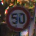

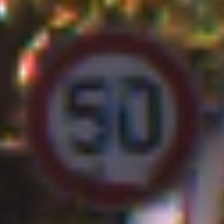

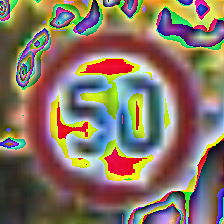

In [15]:
# Anzeigen des Originalbildes
display(bild)

# Anzeigen des gecroppten und angepassten Bildes
img_resized = transform_img(bild)
display(img_resized)

# Anzeigen des normalisierten Bildes
img_normalized = transform_complete(bild)
img_norm = ToPILImage()(img_normalized).convert("RGB")
display(img_norm)

### Anwendung der schichtweisen Relevanzausbreitung (engl. Layer-Wise Relevance Propagation (LRP))
Basierend auf den Forschungsergebnissen von  [Montanov et al.](https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10) und [Kohlbrenner et al.](https://arxiv.org/abs/2304.08984) verwenden wir eine Composite Implementierung die je nach Schicht eine passende LRP-Regel anwendet. Die Composite Implementierung die angewandt wird ist das EpsilonPlusFlat composite. Bei dieser Kombination aus LRP-Regeln werden für die voll vernzete Schicht (engl. Dense Layer) die Epsilon-LRP-Regel angewandt, für faltende Schichten die Z-Plus (alpha-beta) Regel und für die erste Schicht die flat-Regel [[Kohlbrenner et al.](https://arxiv.org/abs/2304.08984)]. Die verwendete Bibliothek zur Implementierung ist die sogenannte Zennit Bilbiothek der Forscher [Andreas et al.](https://arxiv.org/abs/2106.13200)

In [16]:
# Anwenden des VGG Cannonizers weil wir Batch Normalisation verwendet haben
canonizer = VGGCanonizer()

# erstellen des Composites für die LRP-Regeln und Anwendung des Cannonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# hier setzen wir die Zielklasse welche wir von unserer Vorhersage oben übernehmen
target = torch.eye(1000)[[klasse]]

# Spezifizierung des Modells, Composites als Attributor
with Gradient(model=model, composite=composite) as attributor:
    # Berechnung des attributors
    output, attribution = attributor(data.to(device), target.to(device))

Nachdem wir den Canonizer inklusive unseres Composites an Regeln definiert haben, sowie die Zielklasse für welche wir das Bild überprüfen wollen haben wir das Modell initialisiert und die Berechnung des Attributors durchgeführt haben können wir die sich daraus ergebenden Relevanzen über alle Kanäle aufsumieren. Basierend auf diesen summierten Relevanzen erstellen wir uns dann eine Wärmekarte und geben diese aus:

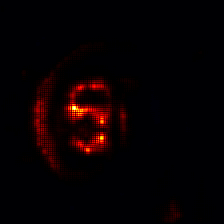

In [17]:
# Summieren über alle Kanäle
relevance = attribution.sum(1)

# Daten auf die CPU schreiben
relevance = relevance.cpu()

# Erzeugen der Heatmap 
img_lrp = imgify(relevance, symmetric=True, cmap='coldnhot')

# Anzeigen der Heatmap
display(img_lrp)

### Zusammenfassender Überblick
Abschließend können wir nochmal alle unsere verwendeten Bilder gegenüberstellen um Schlüsse über die gelernten Merkmale unseres Modell für die prognostizierte Klasse zu ziehen.

Eingangsbild: 


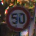

Eingangsbild resized und angepasst für das Netzwerk:


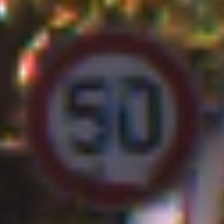

Eingangsbild normalisiert


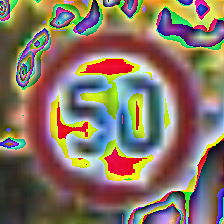


Prognostizierte Klasse: -> Geschwindigkeitsbegrenzung (50km/h)

Schichtweise Relevanzausbreitung Wärmekarte:


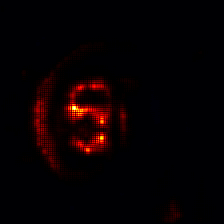

In [18]:
print('Eingangsbild: ')
display(bild)
print('Eingangsbild resized und angepasst für das Netzwerk:')
display(img_resized)
print('Eingangsbild normalisiert')
display(img_norm)
print(f'\nPrognostizierte Klasse: -> {label_names[klasse]}')
print('\nSchichtweise Relevanzausbreitung Wärmekarte:')
display(img_lrp)

### Speichern der Bilder

In [19]:
im1 = img_resized.save("/workspace/normal.png")
im2 = img_lrp.save("/workspace/LRP.png")